# compare the OpenPIV Python with PIVLab


In [1]:
%reload_ext watermark
%watermark -v -m -p numpy,openpiv

CPython 3.8.5
IPython 7.19.0

numpy 1.19.4
openpiv 0.23.2rc0

compiler   : GCC 7.3.0
system     : Linux
release    : 5.4.0-56-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 8
interpreter: 64bit


In [2]:
from openpiv import windef
from openpiv.windef import Settings
from openpiv import tools, scaling, validation, filters, preprocess
from openpiv.pyprocess import extended_search_area_piv, get_field_shape, get_coordinates
from openpiv import smoothn
from openpiv.preprocess import mask_coordinates

import numpy as np
import os
from time import time
import warnings


import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 6.0)


In [3]:
settings = Settings()

# 'Data related settings'
# Folder with the images to process
settings.filepath_images = '../data/'
# Folder for the outputs
settings.save_path = '../OpenPIV_results/'
# Root name of the output Folder for Result Files
settings.save_folder_suffix = 'Test_1'
# Format and Image Sequence
settings.frame_pattern_a = 'karman_16Hz_000_A.jpg'
settings.frame_pattern_b = 'karman_16Hz_000_B.jpg'

'Region of interest'
# (50,300,50,300) #Region of interest: (xmin,xmax,ymin,ymax) or 'full' for full image
settings.ROI = 'full'
# settings.ROI = (200,400,600,850)



settings.deformation_method = 'symmetric' # or 'second image'


settings.iterations = 4  # select the number of PIV passes

# add the interrogation window size for each pass. 
# For the moment, it should be a power of 2 
settings.windowsizes=(64, 32, 16, 6)
settings.overlap=(32, 16, 8, 3)

# settings.windowsizes = (128, 64, 32, 16, 8) # if longer than n iteration the rest is ignored
# The overlap of the interroagtion window for each pass.
# settings.overlap = (64, 32, 16, 8, 4) # This is 50% overlap


# Has to be a value with base two. In general window size/2 is a good choice.
# methode used for subpixel interpolation: 'gaussian','centroid','parabolic'
settings.subpixel_method = 'gaussian'

# order of the image interpolation for the window deformation
settings.interpolation_order = 1
settings.scaling_factor = 1  # scaling factor pixel/meter
settings.dt = 1  # time between to frames (in seconds)
'Signal to noise ratio options (only for the last pass)'
# It is possible to decide if the S/N should be computed (for the last pass) or not
settings.extract_sig2noise = True  # 'True' or 'False' (only for the last pass)
# method used to calculate the signal to noise ratio 'peak2peak' or 'peak2mean'
settings.sig2noise_method = 'peak2peak'
# select the width of the masked to masked out pixels next to the main peak
settings.sig2noise_mask = 2
# If extract_sig2noise==False the values in the signal to noise ratio
# output column are set to NaN

# only effecting the first pass of the interrogation the following passes
# in the multipass will be validated

'Output options'
# Select if you want to save the plotted vectorfield: True or False
settings.save_plot = False
# Choose wether you want to see the vectorfield or not :True or False
settings.show_plot = True
settings.scale_plot = 200  # select a value to scale the quiver plot of the vectorfield
# run the script with the given settings



# 'Processing Parameters'
settings.correlation_method='linear'  # 'circular' or 'linear'
settings.normalized_correlation = True

# 'vector validation options'
# choose if you want to do validation of the first pass: True or False
settings.validation_first_pass = True


settings.filter_method = 'localmean'
# maximum iterations performed to replace the outliers
settings.max_filter_iteration = 10
settings.filter_kernel_size = 3  # kernel size for the localmean method

settings.replace_vectors = True

settings.MinMax_U_disp = (-5, 5)
settings.MinMax_V_disp = (-5, 5)

# The second filter is based on the global STD threshold
settings.std_threshold = 3  # threshold of the std validation

# The third filter is the median test (not normalized at the moment)
settings.median_threshold = 3  # threshold of the median validation
# On the last iteration, an additional validation can be done based on the S/N.
settings.median_size=1 #defines the size of the local median, it'll be 3 x 3


settings.dynamic_masking_method = 'intensity'
settings.dynamic_masking_threshold = 0.1
settings.dynamic_masking_filter_size = 21

# New settings for version 0.23.2c
settings.image_mask = True

# Smoothing after the first pass
settings.smoothn=True #Enables smoothing of the displacemenet field
settings.smoothn_p=0.5 # This is a smoothing parameter


In [4]:
import glob
file_list = sorted(glob.glob('../data/karman_16Hz_*.jpg'))
file_list = file_list[:22]
file_list

['../data/karman_16Hz_000_A.jpg',
 '../data/karman_16Hz_000_B.jpg',
 '../data/karman_16Hz_001_A.jpg',
 '../data/karman_16Hz_001_B.jpg',
 '../data/karman_16Hz_002_A.jpg',
 '../data/karman_16Hz_002_B.jpg',
 '../data/karman_16Hz_003_A.jpg',
 '../data/karman_16Hz_003_B.jpg',
 '../data/karman_16Hz_004_A.jpg',
 '../data/karman_16Hz_004_B.jpg',
 '../data/karman_16Hz_005_A.jpg',
 '../data/karman_16Hz_005_B.jpg',
 '../data/karman_16Hz_006_A.jpg',
 '../data/karman_16Hz_006_B.jpg',
 '../data/karman_16Hz_007_A.jpg',
 '../data/karman_16Hz_007_B.jpg',
 '../data/karman_16Hz_008_A.jpg',
 '../data/karman_16Hz_008_B.jpg',
 '../data/karman_16Hz_009_A.jpg',
 '../data/karman_16Hz_009_B.jpg',
 '../data/karman_16Hz_010_A.jpg',
 '../data/karman_16Hz_010_B.jpg']

../data/karman_16Hz_000_A.jpg ../data/karman_16Hz_000_B.jpg


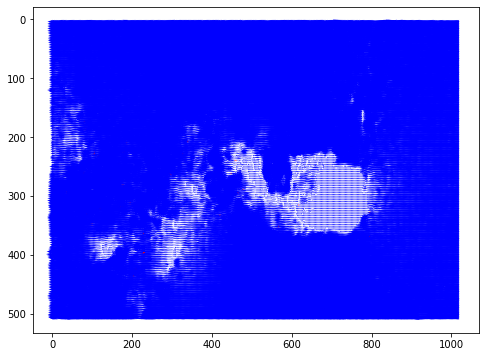

Image Pair 1
../data/karman_16Hz_001_A.jpg ../data/karman_16Hz_001_B.jpg


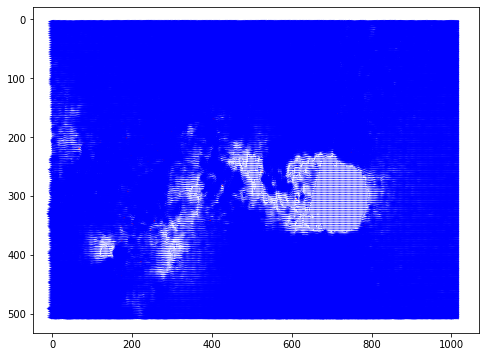

Image Pair 1
../data/karman_16Hz_002_A.jpg ../data/karman_16Hz_002_B.jpg


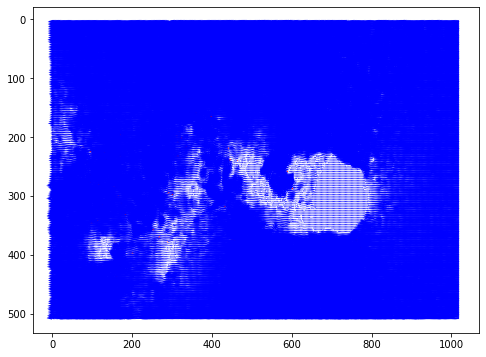

Image Pair 1
../data/karman_16Hz_003_A.jpg ../data/karman_16Hz_003_B.jpg


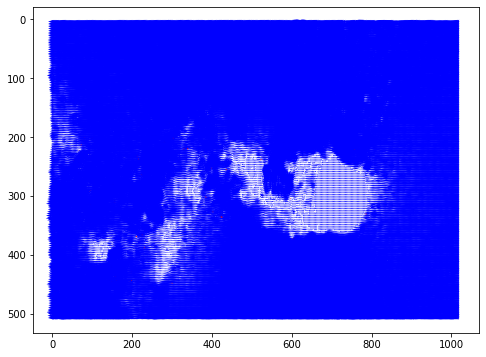

Image Pair 1
../data/karman_16Hz_004_A.jpg ../data/karman_16Hz_004_B.jpg


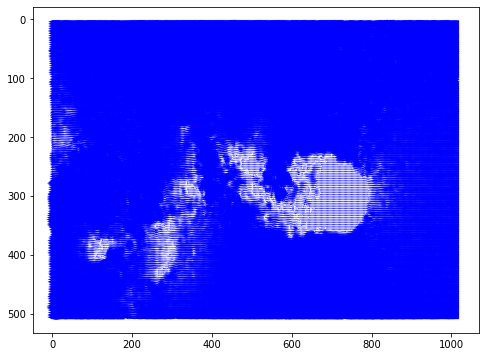

Image Pair 1
../data/karman_16Hz_005_A.jpg ../data/karman_16Hz_005_B.jpg


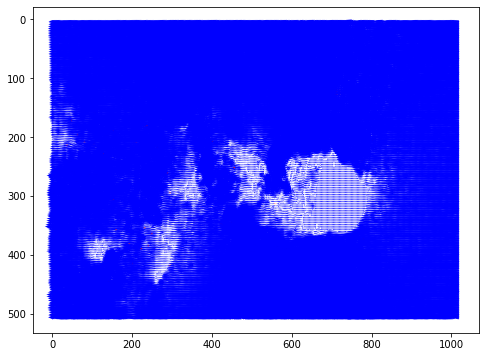

Image Pair 1
../data/karman_16Hz_006_A.jpg ../data/karman_16Hz_006_B.jpg


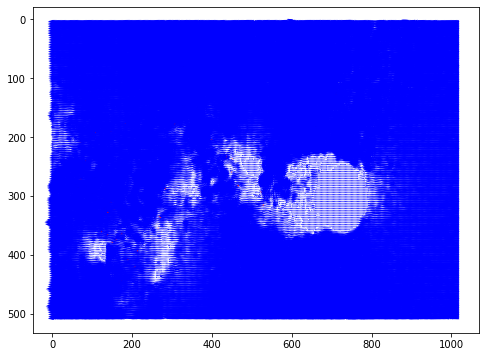

Image Pair 1
../data/karman_16Hz_007_A.jpg ../data/karman_16Hz_007_B.jpg


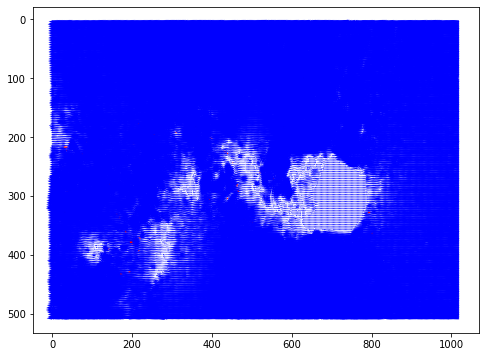

Image Pair 1
../data/karman_16Hz_008_A.jpg ../data/karman_16Hz_008_B.jpg


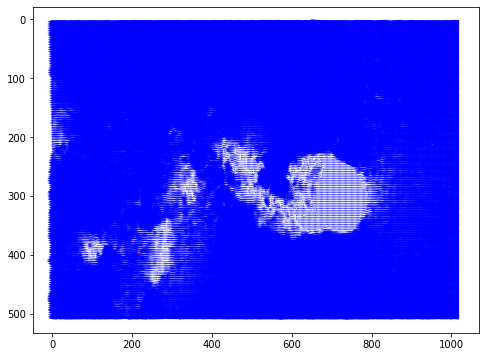

Image Pair 1
../data/karman_16Hz_009_A.jpg ../data/karman_16Hz_009_B.jpg


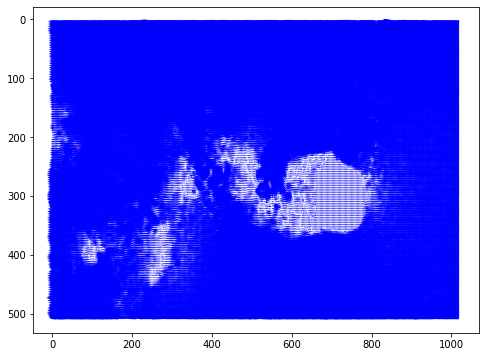

Image Pair 1
../data/karman_16Hz_010_A.jpg ../data/karman_16Hz_010_B.jpg


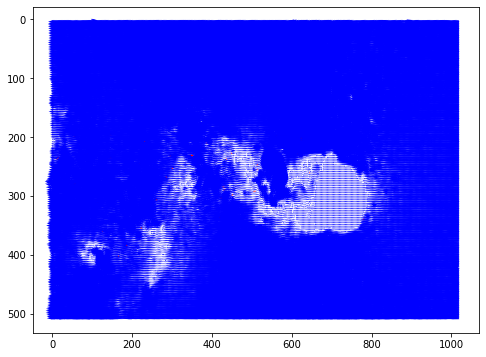

Image Pair 1


In [5]:
N = 11
counter = 0
for a,b in zip(file_list[0:2*N+1:2],file_list[1:2*N+2:2]):
    print(a,b)
    settings.frame_pattern_a = a
    settings.frame_pattern_b = b
    settings.save_folder_suffix = f'{counter}'
    windef.piv(settings)
    counter += 1